In [1]:
from pathlib import Path
path_to_visium_bundle = Path("/srv/gstore/projects/p1001/Visium_HD_Human_Lung_Cancer_post_Xenium_Prime_5K_Experiment2/binned_outputs/square_002um")
tissue_positions_path = Path("/srv/gstore/projects/p1001/Visium_HD_Human_Lung_Cancer_post_Xenium_Prime_5K_Experiment2/binned_outputs/square_002um/spatial/tissue_positions.parquet")
path_to_visium_full_size_image = Path("/srv/gstore/projects/p1001/Visium_HD_Human_Lung_Cancer_post_Xenium_Prime_5K_Experiment2/Visium_HD_Human_Lung_Cancer_post_Xenium_Prime_5K_Experiment2_tissue_image.btf")
path_to_xenium_bundle = Path("/srv/GT/analysis/rdegottardi/data/Xenium_Lung_canc_5k")


In [2]:
import json
from collections import namedtuple, Counter

import numpy as np
import scanpy as sc
import pandas as pd
import zarr

## Image manipulation and geometry
from tifffile import TiffFile
from tifffile import imread
from skimage.io import imread as skimread

# Polygon manipulation and geometry
from shapely.geometry import Polygon
from shapely.geometry import LinearRing

## Plotting imports
from matplotlib import pyplot as plt
from matplotlib.colors import LinearSegmentedColormap, Normalize, to_hex, Colormap
from matplotlib.cm import ScalarMappable

### Functions for registration of Xenium to Visium data and associated analyis and visualization
## Visualization functions
from companion_functions import (
    hexlist_to_cmap,
    polygons_coords_to_patch_collection,
    plot_polygons,
    hex_corner_offset,
    polygon_corners,
    celltypes,
    celltypes,
    hex_codes,
    ctype_to_code_map,
    ctype_hex_map,
    ctype_cmap,
)

## Analysis functions

from companion_functions import (
    unique_encode,
    get_xenium_to_morphology_transform_from_xenium_morphology_image,
    get_xenium_capture_polygon_um,
    transform_coordinates,
    get_median_spot_to_spot_distance_from_centroids,
    generate_space_filling_visium_polygons,
    get_visium_capture_polygon,
    __OUTSIDE_VISIUM_CAPTURE_AREA_BARCODE__,
    bin_xenium_data_to_visium_spots,
    generate_anndata_matrix_from_transcript_assignments,
)

In [3]:
# Function to open a Zarr file
def open_zarr(path: str) -> zarr.Group:
    store = (
        zarr.storage.ZipStore(path, mode="r") if path.endswith(".zip")
        else zarr.storage.LocalStore(path)
    )
    return zarr.open_group(store=store, mode="r")

# For example, use the above function to open the cells Zarr file, which contains segmentation mask Zarr arrays
root = open_zarr(f"{path_to_xenium_bundle}/cells.zarr.zip")

## This is the first manual alignment try, including a slight top-left shift
xenium_morphology_to_visium_full_res_transformation = np.linalg.inv(np.array(
    [[0.009884978864083889,1.2878049164093166,-739.3369283315897],
     [-1.2878049164093166,0.009884978864083889,34491.76426465326],
     [0,0,1]
    ]
)
)

In [4]:
## Transformation matrix exported from Xenium Explorer
xenium_morphology_to_visium_full_res_transformation = np.linalg.inv(np.array(
    [[0.009571792048279185,1.2883813470948917,-753.1522063990942],
     [-1.2883813470948917,0.009571792048279185,34507.277992269606],
     [0,0,1]
    ]
)
)
## Transformation matrix between Xenium full resolution (DAPI) morphology image and the Xenium coordinate system.
xenium_to_morphology_transformation = (
    get_xenium_to_morphology_transform_from_xenium_morphology_image(
        path_to_xenium_bundle / "morphology.ome.tif", 0 
    )
)

## Xenium coordinates must be transformed into image coordinates before being transformed into Visium image coordinates.
## The following describes that combined transformation (a matrix multiplication of the two transformation matrices).
xenium_to_visium_full_res_transformation = (
    xenium_morphology_to_visium_full_res_transformation
    @ xenium_to_morphology_transformation
)

In [5]:
# Load the Visium full resolution image
visium_full_res_image = skimread(path_to_visium_full_size_image)

In [6]:
# Filter polygons to those that overlap the zoomed region
def polygon_in_crop(polygon, x_min, x_max, y_min, y_max):
    # polygon: (N,) array of interleaved x and y coordinates
    xs = polygon[::2]  # x coordinates are at even indices
    ys = polygon[1::2] # y coordinates are at odd indices
    return (
        (xs >= x_min).any() and (xs < x_max).any() and
        (ys >= y_min).any() and (ys < y_max).any()
    )

In [7]:
# Define the center and zoom region (same as before)
center_x, center_y = 2000, 2000
size = 1000
x_min, x_max = center_x, center_x + size
y_min, y_max = center_y, center_y + size


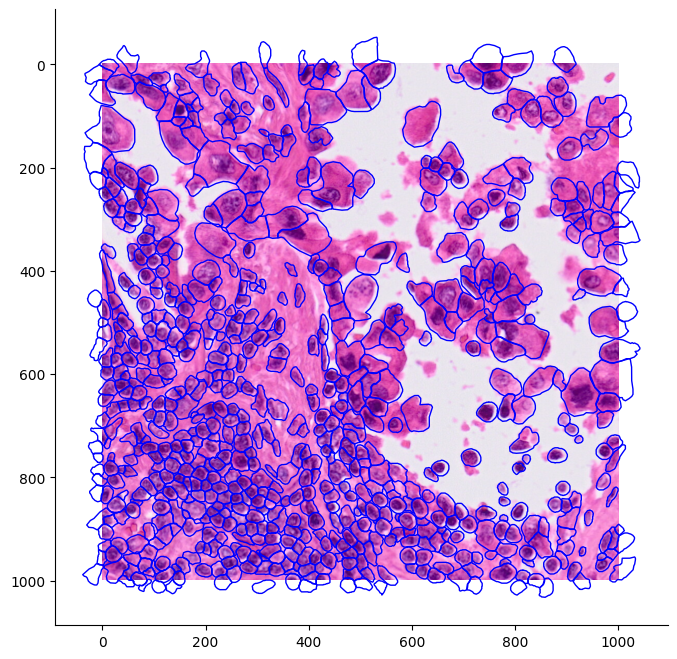

In [8]:
cell_vertices = root["polygon_sets"]["1"]["vertices"][:]
num_cells = int(root["polygon_sets"]["1"]["vertices"][:].shape[0])
num_vertices = int(root["polygon_sets"]["1"]["vertices"][:].shape[1]/2)
reshaped_cell_vertices = cell_vertices.reshape(num_cells, num_vertices, 2)


xenium_cell_polygons = []
for cell_vertices in reshaped_cell_vertices:
    transformed_vertices = transform_coordinates(
        cell_vertices,
        xenium_to_visium_full_res_transformation,
    )
    xenium_cell_polygons.append(transformed_vertices)

xenium_cell_polygons = np.array(xenium_cell_polygons)
# Reshape the transformed vertices to have alternating x and y coordinates
xenium_polygons_interleaved = []
for cell_vertices in xenium_cell_polygons:
    interleaved_vertices = cell_vertices.flatten()
    xenium_polygons_interleaved.append(interleaved_vertices)

xenium_cell_polygons = np.array(xenium_polygons_interleaved)

fig = plt.figure(figsize=(8, 8))
ax = plt.gca()

# Show zoomed region of the full resolution image
ax.imshow(
    visium_full_res_image[y_min:y_max, x_min:x_max]
)

filtered_cell_polygons = [
    poly for poly in xenium_cell_polygons
    if polygon_in_crop(poly, x_min, x_max, y_min, y_max)
]

# Shift polygons so they match the crop region
def shift_polygon(polygon, x_min, y_min):
    shifted_polygon = polygon.copy()
    shifted_polygon[::2] -= x_min  # Subtract x_min from x coordinates
    shifted_polygon[1::2] -= y_min # Subtract y_min from y coordinates
    return shifted_polygon

shifted_polygons = [shift_polygon(poly, x_min, y_min) for poly in filtered_cell_polygons]

# Convert shifted polygons to (N, 2) arrays for plot_polygons
cell_polygons = [poly.reshape(-1, 2) for poly in shifted_polygons]

plot_polygons(
    cell_polygons,
    ax=ax,
    facecolor=(0, 0, 0, 0),
    edgecolor="blue",
    linewidth=1,
)

# Plot style adjustments
ax.spines.right.set_visible(False)
ax.spines.top.set_visible(False)
ax.yaxis.set_ticks_position("left")
ax.xaxis.set_ticks_position("bottom")
ax.set_aspect("equal", adjustable="box")

# Export the polygons

This is required to match the coordinates in enact (croped wsi image)

In [9]:
cell_polygons_df = pd.DataFrame({
    "Unnamed: 0": [i for i in range(len(xenium_cell_polygons))],
    "geometry": [
        Polygon(LinearRing(polygon.reshape(-1, 2))) for polygon in xenium_cell_polygons
    ],
    "id": [f"ID_{i+1}" for i in range(len(xenium_cell_polygons))],
    "cell_x": [polygon.reshape(-1, 2)[:, 0].mean() for polygon in xenium_cell_polygons],
    "cell_y": [polygon.reshape(-1, 2)[:, 1].mean() for polygon in xenium_cell_polygons],
    "centroid": [
        (polygon.reshape(-1, 2)[:, 0].mean(), polygon.reshape(-1, 2)[:, 1].mean()) for polygon in xenium_cell_polygons
    ]
})

In [10]:
"""Get the crop location of the image to adjust the coordinates accordingly
Function from ENACT pipeline
Returns:
    _type_: _description_
"""
tissue_pos_list = pd.read_parquet(tissue_positions_path)

# Cleaning up, removing negative coords,removing out of tissue bins
tissue_pos_list_filt = tissue_pos_list[tissue_pos_list.in_tissue == 1]
tissue_pos_list_filt = tissue_pos_list_filt.copy()
tissue_pos_list_filt["pxl_row_in_fullres"] = tissue_pos_list_filt[
    "pxl_row_in_fullres"
].astype(int)
tissue_pos_list_filt["pxl_col_in_fullres"] = tissue_pos_list_filt[
    "pxl_col_in_fullres"
].astype(int)
tissue_pos_list_filt = tissue_pos_list_filt.loc[
    (tissue_pos_list_filt.pxl_row_in_fullres >= 0)
    & (tissue_pos_list_filt.pxl_col_in_fullres >= 0)
]
x_tmin = tissue_pos_list_filt["pxl_col_in_fullres"].min()
y_tmin = tissue_pos_list_filt["pxl_row_in_fullres"].min()
x_tmax = tissue_pos_list_filt["pxl_col_in_fullres"].max()
y_tmax = tissue_pos_list_filt["pxl_row_in_fullres"].max()
crop_bounds = (x_tmin, y_tmin, x_tmax, y_tmax)

In [11]:
filtered_enact_cell_polygons_df = cell_polygons_df[
    (cell_polygons_df["cell_x"] >= crop_bounds[0]) & (cell_polygons_df["cell_x"] <= crop_bounds[2]) &
    (cell_polygons_df["cell_y"] >= crop_bounds[1]) & (cell_polygons_df["cell_y"] <= crop_bounds[3])
].copy()

# Shift the coordinates
filtered_enact_cell_polygons_df["cell_x"] = filtered_enact_cell_polygons_df["cell_x"] - crop_bounds[0]
filtered_enact_cell_polygons_df["cell_y"] = filtered_enact_cell_polygons_df["cell_y"] - crop_bounds[1]

# Shift the geometry
def shift_polygon(polygon, x_min, y_min):
    shifted_coords = [(x - x_min, y - y_min) for x, y in polygon.exterior.coords]
    return Polygon(shifted_coords)

filtered_enact_cell_polygons_df["geometry"] = filtered_enact_cell_polygons_df["geometry"].apply(lambda geom: shift_polygon(geom, crop_bounds[0], crop_bounds[1]))

filtered_enact_cell_polygons_df.to_csv("nuclei_df_bugy.csv", index=False) #the cells must be named nuclei to be cosidered as the enact segmentation
# Display the first few rows of the DataFrame
filtered_enact_cell_polygons_df.head()

,Unnamed: 0,geometry,id,cell_x,cell_y,centroid
0,0,"POLYGON ((8153.67138671875 3387.9892578125, 81...",ID_1,8140.082031,3389.301025,"(8140.082, 3528.301)"
1,1,"POLYGON ((8016.0625 3461.97119140625, 8011.365...",ID_2,8001.863770,3468.875977,"(8001.864, 3607.876)"
2,2,"POLYGON ((8074.77099609375 3424.279052734375, ...",ID_3,8062.876953,3423.901855,"(8062.877, 3562.9019)"
3,3,"POLYGON ((7977.92236328125 3447.507568359375, ...",ID_4,7965.357910,3452.940918,"(7965.358, 3591.941)"
4,4,"POLYGON ((8033.126953125 3251.503173828125, 80...",ID_5,8022.653809,3250.059326,"(8022.654, 3389.0593)"


proceed with fix_polygons.ipynb

In [12]:
filtered_enact_cell_polygons_df

,Unnamed: 0,geometry,id,cell_x,cell_y,centroid
0,0,"POLYGON ((8153.67138671875 3387.9892578125, 81...",ID_1,8140.082031,3389.301025,"(8140.082, 3528.301)"
1,1,"POLYGON ((8016.0625 3461.97119140625, 8011.365...",ID_2,8001.863770,3468.875977,"(8001.864, 3607.876)"
2,2,"POLYGON ((8074.77099609375 3424.279052734375, ...",ID_3,8062.876953,3423.901855,"(8062.877, 3562.9019)"
3,3,"POLYGON ((7977.92236328125 3447.507568359375, ...",ID_4,7965.357910,3452.940918,"(7965.358, 3591.941)"
4,4,"POLYGON ((8033.126953125 3251.503173828125, 80...",ID_5,8022.653809,3250.059326,"(8022.654, 3389.0593)"
...,...,...,...,...,...,...
277653,277653,"POLYGON ((18131.0234375 21528.193359375, 18126...",ID_277654,18111.076172,21530.296875,"(18111.076, 21669.297)"
277654,277654,"POLYGON ((17868.455078125 21184.75, 17867.6718...",ID_277655,17860.937500,21188.312500,"(17860.938, 21327.312)"
277655,277655,"POLYGON ((18025.462890625 21214.62890625, 1802...",ID_277656,18015.505859,21215.572266,"(18015.506, 21354.572)"
277656,277656,"POLYGON ((18387.8671875 21205.7265625, 18386.2...",ID_277657,18380.259766,21218.140625,"(18380.26, 21357.14)"
